In [9]:
using PyPlot
using LinearAlgebra
using SciMLBase
using SciMLSensitivity
using FFTW
using Zygote
using OrdinaryDiffEq
using ApproxFun
using Sundials
using DiffEqDevTools
using PyCall
using ForwardDiff
using AbstractFFTs
using FiniteDiff
using TerminalLoggers
using ProgressMeter
using Random
using MAT
using DelimitedFiles
using ForwardDiff

The functions in the cell below do the following: the first, "e_drive" specifies a time-dependent driving electric field (SI units) in terms of an amplitude, a carrier frequency, a pulse duration, and an initial phase. 

The second, "phonon_hhg", instantiates the right-hand-side of the Newton equations governing the time evolution of the position and momentum of an optical phonon mode. The "a" parameters are coefficients specifying the nonlinear potential (see von Hoegen et. al. Nature (2018)). The gamma parameter is a dissipation rate which is set to zero in what follows, but can be incorporated in the mean-field dynamics and the quantum noise dynamics. The parameter Z is the Born effective charge.

In [10]:
function e_drive(t,e0,τ,ω_d,ϕ)
    et = e0*exp(-t^2/τ^2)*sin(ω_d*t+ϕ);
    return et
end

function phonon_hhg(du, u, p, t)
    # u[1] = Q1, u[2] = P1, u[3] = Q2, u[4] = P2
    
    a_2 = p[1];
    a_3 = p[2];
    a_4 = p[3]; 
    a_5 = p[4];
    Z = p[5];
    γ = p[6];
    e0 = p[7];
    τ = p[8];
    ω_d = p[9];
    ϕ = p[10];
    
    du[1] = u[2];
    du[2] = -γ*u[2] -a_2*u[1] - a_3*u[1]^2 - a_4*u[1]^3 - a_5*u[1]^4 + Z*e_drive(t,e0,τ,ω_d,ϕ);
    
    return du
end

phonon_hhg (generic function with 1 method)

This cell defines parameters relevant to the simulations underlying Figure 2.

In [11]:
qe = 1.6e-19;
ħ = 1.05e-34;
amu = 1.66e-27;
thz = 1e12;
angstrom = 1e-10;
mev = 1e-3*qe;
mev_frequency = mev/ħ;

# time_unit = ω_1;
a_2 = 927*mev/angstrom^2/amu
ω_ph = sqrt(a_2);
Q0 = sqrt(ħ/2/ω_ph);
a_3 = 1.0*1567.65*mev/angstrom^3/(amu)^(3/2)
a_4 = 1.0*900.8*mev/angstrom^4/amu^2
a_5 = 1*7*mev/angstrom^5/(amu)^(5/2);
Z = (1)*qe/sqrt(amu);
γ = 0*2*π*1e12;

e0 = 100*1e8; # volt/meter
τ = 1*150e-15;
ω_d = 17.5*2π*thz;
ϕ = 0;

p = [a_2,a_3,a_4,a_5,Z,γ,e0,τ,ω_d,ϕ];

The cell below plots the potential assumed. This corresponds to Fig. 2b in the manuscript.

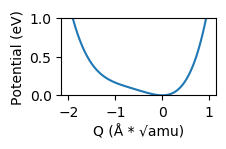

(0, 1)

In [12]:
figure(figsize=(2,1))
Q_list = [-2:0.01:1;]*angstrom*sqrt(amu);
V_Q = (1/2)*ω_ph^2*Q_list.^2 + (1/3)*a_3*Q_list.^3 + (1/4)*a_4*Q_list.^4 + (1/5)*a_5*Q_list.^5;
plot(Q_list / (angstrom*sqrt(amu)),V_Q/qe)
xticks([-2,-1,0,1])
xlabel("Q (Å * √amu)")
ylabel("Potential (eV)")
ylim(0,1)

The cell below integrates the Newton equations of motion using the DifferentialEquations package in Julia ("solve" is the function which integrates the differential equation). The function "get_soln" does the same thing, but wraps the process into a single function. The function "get_x_soln_reduced" produces $Q,P$ at the final time (t_final) assuming a known t_final and parameter set p. This redefinition of a single-argument function is needed to take derivatives with respect to initial conditions using existing packages in Julia.

In [13]:
t_final = 15*2*π/ω_d

u0 = [0,0]
tspan = (0.0, t_final);
prob = ODEProblem(phonon_hhg, u0, tspan, p)
sol = solve(prob,Rosenbrock23(), abstol=1e-15,saveat=1e-15;);

t_final = 15*2*π/ω_d

function get_soln(init_conds,t,p)
    
    tspan = (0.0, t)
    prob = ODEProblem(phonon_hhg, init_conds, tspan, p)
    sol = solve(prob,Rosenbrock23(), abstol=1e-15);
    q_out = sol.u[end][1];
    p_out = sol.u[end][2];
    X = [q_out p_out]
    
    return real(X)
end

get_x_soln_reduced(x) = get_soln(x,t_final,p);

The cell below uses the quantum sensitivity analysis framework to compute the position and momentum variances as a function of time, corresponding to Fig. 2d.

In [14]:
t_final_list = [0.0:0.01:1.5;]*2*π/ω_ph;
nt = length(t_final_list)

x_final_list = zeros(nt);
p_final_list = zeros(nt);
dx2_final_list = zeros(nt);
dp2_final_list = zeros(nt);

# mean position assumed for the ground state. The mean momentum is also addumed to be zero.
x_init_gs = 0.0;
p_init_gs = 0.0;

# variances of X and P for the ground state.
x2t_gs = 1.0;
p2t_gs = 1.0;

# For each time, we find the final classical X and P, and using ForwardDiff.jacobian, compute the derivative
# of the final X and P with respect to the initial conditions. The quadrature sum rule in the manuscript then
# allows us to get the final variances.

for ii = 1:nt
    t_final = t_final_list[ii];
    final_state = get_soln([x_init_gs, 0.0],t_final,p);
    x_final_list[ii] = final_state[1];
    p_final_list[ii] = final_state[2];
    get_x_soln_reduced(x) = get_soln(x,t_final,p);
    hhg_jacobian = ForwardDiff.jacobian(get_x_soln_reduced,[x_init_gs, p_init_gs])
    dx2=abs(hhg_jacobian[1,1])^2 * x2t_gs + abs(hhg_jacobian[1,2])^2 * ω_ph^2 * p2t_gs;
    dp2=abs(hhg_jacobian[2,1])^2 / ω_ph^2 * x2t_gs + abs(hhg_jacobian[2,2])^2 * p2t_gs;
    dx2_final_list[ii] = dx2;
    dp2_final_list[ii] = dp2;
end

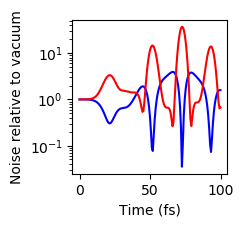

PyObject Text(24.000000000000007, 0.5, 'Noise relative to vacuum')

In [15]:
# The commented out lines place markers over certain points on the curve, some of which 
# are labeled by letters in the main text. I also comment out a line that saves the figure.

#dd = 11;
figure(figsize=(2,2))
#semilogy(1e15*t_final_list[1:dd:end],dx2_final_list[1:dd:end],"o",color="b")
semilogy(1e15*t_final_list,dx2_final_list,color="b")
#semilogy(1e15*t_final_list[1:dd:end],dp2_final_list[1:dd:end],"o",color="r")
semilogy(1e15*t_final_list,dp2_final_list,color="r")
#savefig("phonon_hhg_squeezing.svg",dpi=300,bbox_inches="tight");
xlabel("Time (fs)")
ylabel("Noise relative to vacuum")

This cell makes Fig. 2c, by: plotting the mean-field solution in phase-space (black line), and also plotting at the evolution of a distribution of n_itr=200 initial conditions around (Q,P) = (0,0). This spread represents the effect of quantum vacuum fluctuations, with variances representative of the ground state of the quantum harmonic oscillator. The resulting distributions after nonlinear evolution are plotted for 6 times at times with indices given by t_inds. 

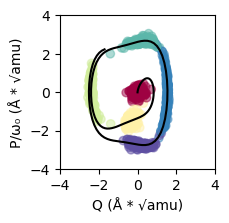

In [16]:
Random.seed!(1234)
# Defines number of initial conditions
n_itr = 200;

# Resets parameters and final time
p = [a_2,a_3,a_4,a_5,Z,γ,e0,τ,ω_d,ϕ];

t_final = 1.5*2*π/ω_ph
dt_final = t_final_list[2] - t_final_list[1];

# Solves for mean-field dynamics
u0 = [0,0]
tspan = (0.0, t_final);
prob = ODEProblem(phonon_hhg, u0, tspan, p)
sol = solve(prob,Rosenbrock23(), abstol=1e-15,saveat=dt_final;);

# Plots the black line
t_out = sol.t;
q_out = [sol.u[ii][1] for ii = 1:length(sol.u)]/angstrom/sqrt(amu);
p_out = [sol.u[ii][2] for ii = 1:length(sol.u)]/ω_ph/angstrom/sqrt(amu);

figure(figsize=(2,2))
plot(q_out,p_out,color="k",alpha=1)

# Sets times to plot the evolved distribution
t_inds = [1 56 78 100 111 122]

# Solves for and plots the distribution of initial conditions after nonlinear evolution for the times
# whose indices are in t_inds.

for ii=1:n_itr;

    u0 = [Q0*randn(),ω_ph*Q0*randn()]
    tspan = (0.0, t_final);
    prob = ODEProblem(phonon_hhg, u0, tspan, p)
    sol_1 = solve(prob,Rosenbrock23(), abstol=1e-15,saveat=dt_final;);

    t_out_1 = sol_1.t;
    q_out_1 = [sol_1.u[ii][1] for ii = 1:length(sol_1.u)]/angstrom/sqrt(amu);
    p_out_1 = [sol_1.u[ii][2] for ii = 1:length(sol_1.u)]/ω_ph/angstrom/sqrt(amu);

    scatter(q_out_1[t_inds],p_out_1[t_inds],c=t_out_1[t_inds]*1e15,linewidths=1,cmap="Spectral",alpha=0.5)
    xlim(-4,4)
    ylim(-4,4)
    xticks([-4,-2,0,2,4])
    yticks([-4,-2,0,2,4])
    #colorbar()
    
end
xlabel("Q (Å * √amu)")
ylabel("P/ω₀ (Å * √amu)")
#colorbar()
#savefig("qsa_trajectories_phonon_hhg.png",dpi=600,bbox_inches="tight");